In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="ticks", font_scale=1.2)

import pandas as pd
import numpy as np
from scipy import stats as st

import warnings
warnings.filterwarnings('ignore')

import sys, os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from utils import *
from data_generating_funcs import *

In [85]:
# full model training
results = []
network_width = 50
exp_iter = 1
rho = .75
true_vi1 = 1.5**2*(1-rho**2)

#beta = [1.5, 1.2, 1, 0, 0, 0] 
beta = [1.5, 1.2, 1, 0, 0, 0]
X, y = generate_linear_data(beta, N=5000, corr=rho)

n, p = X.shape
hidden_layers = [network_width]
tol = 1e-3
results = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = exp_iter)
trainset = torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                          torch.tensor(y_train, dtype=torch.float32).view(-1,1))
train_loader = DataLoader(trainset, batch_size=256)

full_nn = NN4vi(p, hidden_layers, 1)
early_stopping = EarlyStopping('val_loss', min_delta=tol)
trainer = pl.Trainer(callbacks=[early_stopping])
t0 = time.time()
with io.capture_output() as captured: trainer.fit(full_nn, train_loader, train_loader)
full_time = time.time() - t0
full_pred_test = full_nn(X_test)
results.append(['all', 'full model', full_time, 0,
                nn.MSELoss()(full_nn(X_train), y_train).item(),
                nn.MSELoss()(full_pred_test, y_test).item()])
nn.MSELoss()(full_pred_test, y_test)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 401   
------------------------------------
401       Trainable params
0         Non-trainable params
401       Total params
0.002     Total estimated model params size (MB)


tensor(0.0258, grad_fn=<MseLossBackward0>)

In [86]:
j = 0

varr = 'X' + str(j + 1)
# DROPOUT
X_test_change = dropout(X_test, j)
X_train_change = dropout(X_train, j)
dr_pred_train = full_nn(X_train_change)
dr_pred_test = full_nn(X_test_change)
dr_train_loss = nn.MSELoss()(dr_pred_train, y_train).item()
dr_test_loss = nn.MSELoss()(dr_pred_test, y_test).item()
dr_vi = nn.MSELoss()(dr_pred_test, y_test).item() - nn.MSELoss()(full_pred_test, y_test).item()

results.append([varr, 'dropout', 0, dr_vi, dr_train_loss, dr_test_loss])
dr_test_loss

2.3016958236694336

Lazy vi for different values of $\lambda$

In [100]:
# lazy ridge parameter
results = []
grads, flat_params, shape_info = extract_grad(X_train_change, full_nn)
#for lam in np.logspace(0, 2, 50):
for lam in np.arange(1, 20):
    lazy_pred_train, lazy_pred_test = lazy_predict(grads, flat_params, full_nn, hidden_layers, shape_info,
                                                               X_train_change, y_train, X_test_change,lam)
    results.append([lam, nn.MSELoss()(lazy_pred_test, y_test).item() - nn.MSELoss()(full_pred_test, y_test).item()])

<AxesSubplot:xlabel='lam'>

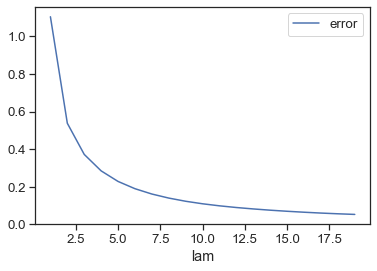

In [101]:
df = pd.DataFrame(results, columns=['lam', 'vi'])#.plot(0,1)
df['error'] = df.vi - true_vi1
df.plot('lam', 'error')
#plt.axhline(.98)
#plt.axhline(dr_vi)

Early stopping

In [ ]:
early_stops = []
for steps in np.arange(1, 20):
    print(steps)
    t0 = time.time()
    retrain_pred_train, retrain_pred_test = fake_retrain(p, full_nn, hidden_layers, j, X_train_change, y_train,
                                                         X_test_change, tol=tol, max_epochs=steps)
    retrain_time = time.time() - t0
    vi_retrain = nn.MSELoss()(retrain_pred_test, y_test).item() - nn.MSELoss()(y_test, full_pred_test).item()
    loss_rt_test = nn.MSELoss()(retrain_pred_test, y_test).item()
    loss_rt_train = nn.MSELoss()(retrain_pred_train, y_train).item()

    early_stops.append([steps, retrain_time, vi_retrain, loss_rt_test])

df2 = pd.DataFrame(early_stops, columns=['steps', 'time', 'vi', 'loss'])

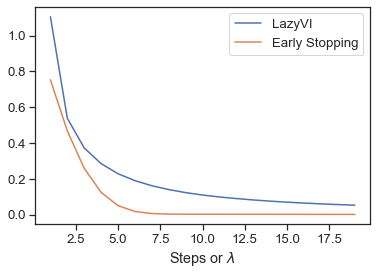

In [110]:
dff = pd.merge(df, df2, left_on='lam', right_on='steps')
dff = dff.rename(columns={'error_x':'LazyVI', 'error_y':'Early Stopping', 'lam':'Steps or $\lambda$'})
dff[['Steps or $\lambda$', 'LazyVI', 'Early Stopping']].plot('Steps or $\lambda$')
plt.savefig("../results/images/early_stopping_regularization.pdf", format='pdf', bbox_inches = "tight")

#[['lam', 'error_x', 'error_y']].plot('lam')